# Graphing the data

### Initial setup

In [1]:
import os

import pandas as pd
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d

import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/ck/b19_nls521zfh84xr344qc0h0000gn/T/ipykernel_30462/1931231309.py:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


### Defining a function to calculate distance between coordinates

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface using the haversine formula.

    Args:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.

    Returns:
        float: The distance between the two points (in kilometers).
    """
    # Convert latitude and longitude to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth's radius in kilometers
    distance = c * r

    return distance

### Importing the clean data

In [3]:
csv_file_path = 'strava_clean_csv_data/jog_1.csv'

# Read the CSV data into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Convert the 'time' column to datetime type
df['time'] = pd.to_datetime(df['time'])

# Calculating distance
df['distance'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], df.loc[row.name - 1, 'latitude'], df.loc[row.name - 1, 'longitude']) if row.name != 0 else 0, axis=1)

### Compare pace with elevation change

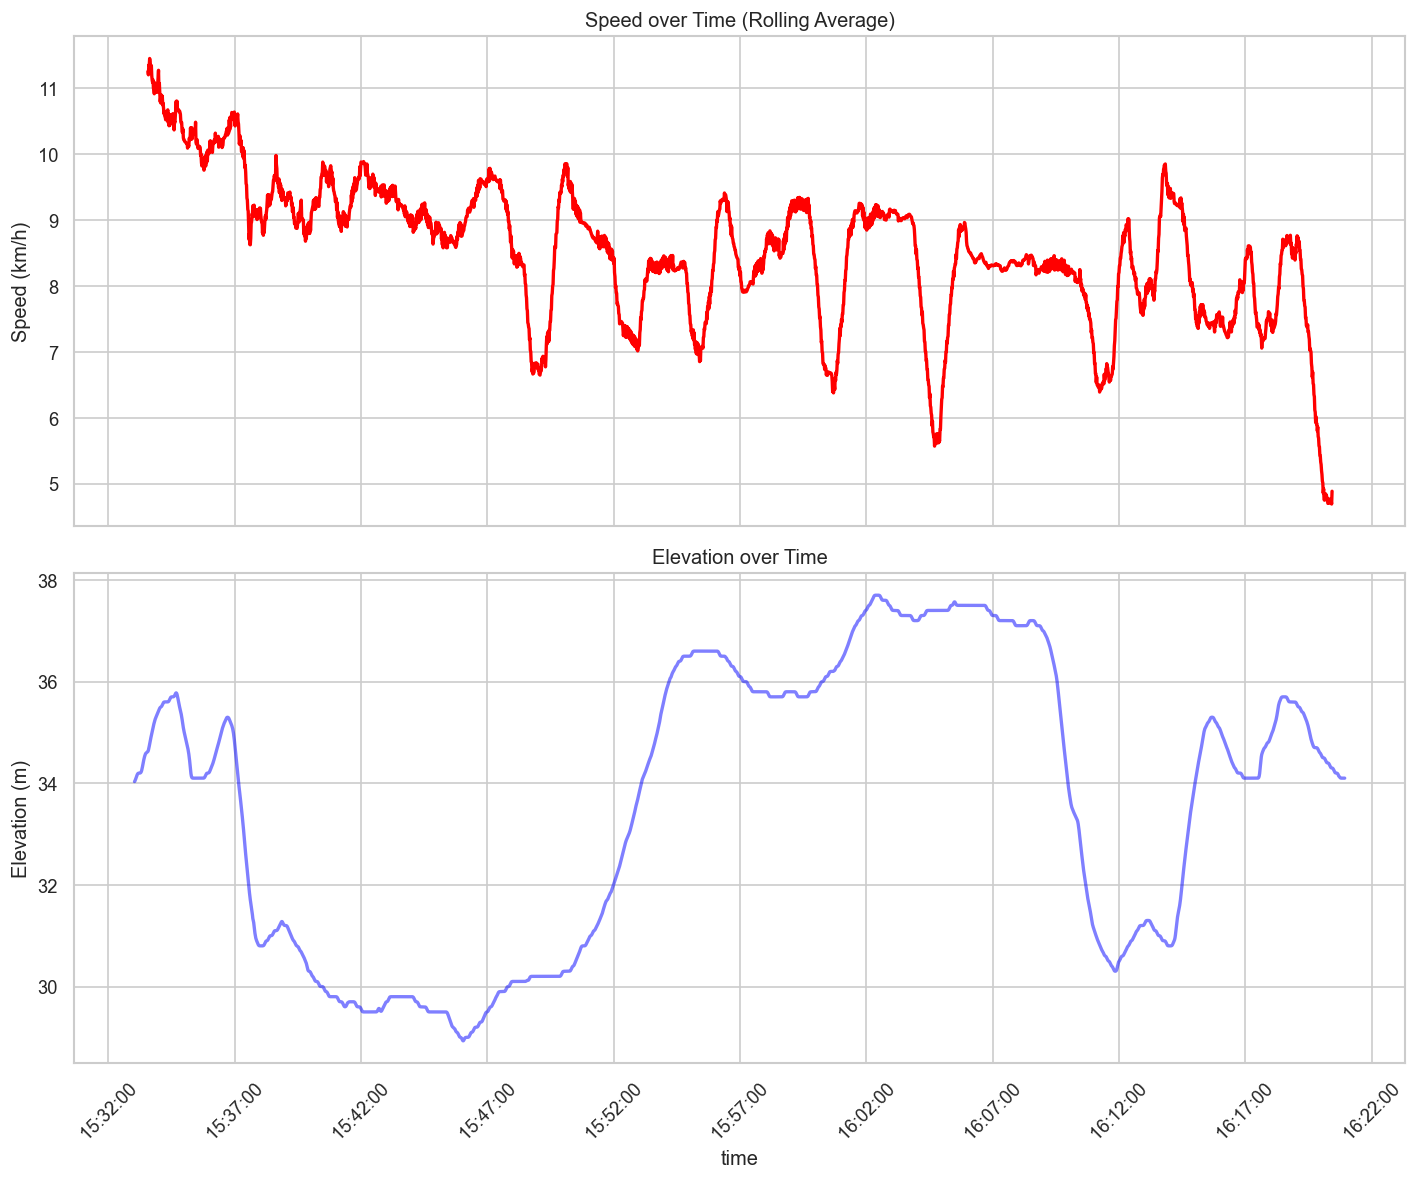

In [4]:
import matplotlib.dates as mdates

sns.set(style="whitegrid")

# Graph 1: Speed over Time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=120, sharex=True, gridspec_kw={'height_ratios': [1, 1]})  # Create subplots with shared x-axis and different heights

smoothed_elevation = gaussian_filter1d(df['elevation'], sigma=2)  # Apply smoothing using Gaussian filter

sns.lineplot(x=df['time'], y=smoothed_elevation, ax=ax2, linewidth=2, color='blue', alpha=0.5)  # Adjust line style and add transparency
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Elevation over Time')

# Graph 2: Elevation over Time
df['speed'] = df['distance'] / df['time'].diff().dt.total_seconds() * 3600  # Convert to km/h

rolling_avg_speed = df['speed'].rolling(window=60, center=True).mean()  # Apply rolling mean with window size of 60

sns.lineplot(x=df['time'], y=rolling_avg_speed, ax=ax1, linewidth=2, color='red')  # Adjust line style and change color
ax1.set_ylabel('Speed (km/h)')
ax1.set_title('Speed over Time (Rolling Average)')

# Format x-axis labels as time
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Compare pace improvement over repeated runs

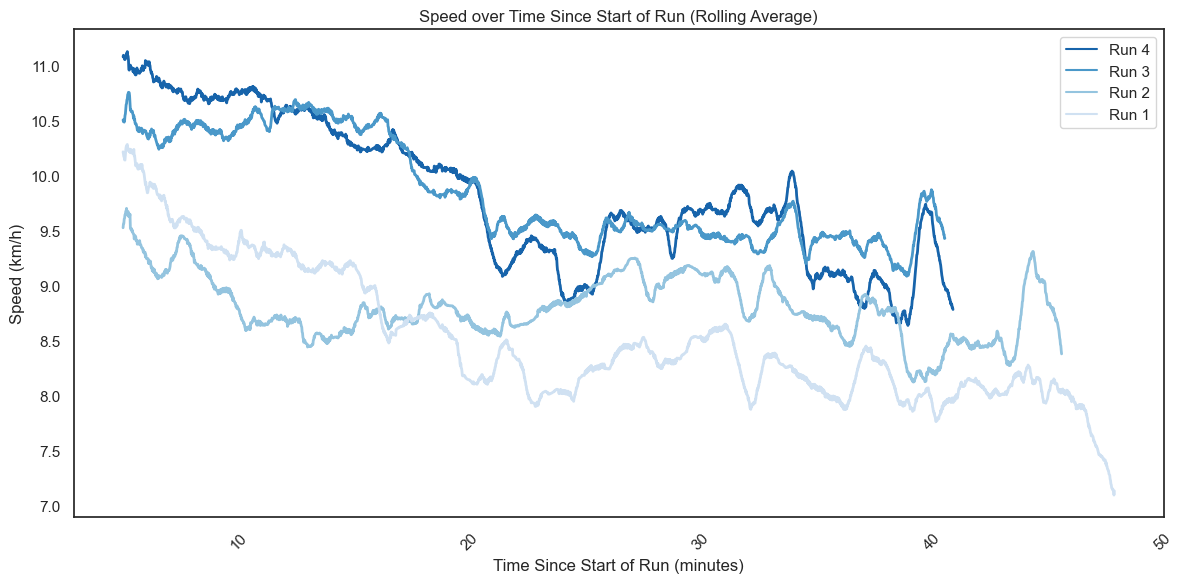

In [5]:
# Folder path containing the CSV files
folder_path = 'strava_clean_csv_data'

# Create a list to store all dataframes
dataframes = []

# Iterate over the CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(folder_path, filename)

        # Read the CSV data into a pandas DataFrame
        df = pd.read_csv(csv_file_path)

        # Convert the 'time' column to datetime type
        df['time'] = pd.to_datetime(df['time'])

        # Calculating distance
        df['distance'] = df.apply(
            lambda row: haversine(
                row['latitude'], row['longitude'], df.loc[row.name - 1, 'latitude'], df.loc[row.name - 1, 'longitude']
            )
            if row.name != 0
            else 0,
            axis=1,
        )

        # Calculate elapsed time since the start of the run
        df['elapsed_time'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds() / 60  # Convert to minutes

        # Calculate speed, excluding the first data point
        df['speed'] = df['distance'] / df['elapsed_time'].diff()*60

        # Get the frequency of elapsed time values
        time_frequency = df['elapsed_time'].diff().median()

        # Calculate the number of data points for the rolling average window
        window_size = pd.Timedelta(minutes=5).total_seconds() / time_frequency / 60

        # Apply rolling average
        df['rolling_avg_speed'] = df['speed'].rolling(window=int(window_size), min_periods=1).mean()

        # Add a 'file' column to represent the source file (so we can separate by jog attempt)
        df['file'] = os.path.splitext(filename)[0]
        
        # Filter out the first 5 minutes of time
        df = df[df['elapsed_time'] >= 5]

        # Append the dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

# Generate the color palette
sequential_colors = sns.color_palette("Blues", 4)[::-1]

# Plot the combined data
plt.figure(figsize=(12, 6))
sns.set(style="white")
sns.lineplot(data=combined_df, x='elapsed_time', y='rolling_avg_speed', hue='file', palette=sequential_colors, linewidth=2)
plt.xlabel('Time Since Start of Run (minutes)')
plt.ylabel('Speed (km/h)')
plt.title('Speed over Time Since Start of Run (Rolling Average)')
plt.xticks(rotation=45)
plt.tight_layout()

# Get the handles and labels of the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Modify the legend labels
new_labels = [f"Run {i+1}" for i, label in enumerate(labels)][::-1]

# Update the legend
plt.legend(handles, new_labels)

# Save the figure
plt.savefig("running_pace_over_time.png")

plt.show()